In [1]:
%load_ext autoreload
%autoreload 2
from exojax.spec import make_numatrix,voigt,lorentz
from exojax.spec import rtransfer as rt
from exojax.spec import planck
import numpy as np
import jax.numpy as jnp
from jax import random
from jax.lax import map, scan
from jax import vmap, jit
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('bmh')

/home/kawahara/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import hapi
hapi.db_begin('/home/kawahara/exojax/data/CO')

HAPI version: 1.1.2.0
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005
Using /home/kawahara/exojax/data/CO

05_hit12
                     Lines parsed: 4606


In [3]:
#hapi.describeTable('05_HITEMP2019')

In [4]:
import pandas as pd
dat=pd.read_csv("/home/kawahara/exojax/data/CO/05-1.0E-03bar_1.0E+00.dat",delimiter=",")

In [5]:
w=np.array(dat["wav"])*1.e4
absco=dat["absco"]

In [6]:
wls = w[::-1]* u.Angstrom
wls[380000:420000]

NameError: name 'u' is not defined

In [102]:
import numpy as np
import astropy.units as u
#nm
llow=2290.0
lhigh=2450.0
#cm-1
wlow=1.e7/lhigh
whigh=1.e7/llow


wls = w[::-1]* u.Angstrom #(np.arange(22900, 24500, 0.1) * u.Angstrom)[::-1]
#wls=wls[380000:420000]
nus = wls.to(1/u.cm, equivalencies=u.spectral()).value
wls = wls.value
nu_lo, nu_hi = nus.min().astype(np.int), nus.max().astype(np.int)

In [104]:
len(nus[::])

331

In [8]:
wlow,whigh


(4081.6326530612246, 4366.812227074236)

In [9]:
nus, wls = jnp.array(nus), jnp.array(wls)

In [81]:
molec='05_hit12'
A_all = hapi.getColumn(molec, 'a')
n_air_all = hapi.getColumn(molec, 'n_air')
gamma_air_all = hapi.getColumn(molec, 'gamma_air')
gamma_self_all = hapi.getColumn(molec, 'gamma_self')
nu_lines_all = hapi.getColumn(molec, 'nu')
delta_air_all = hapi.getColumn(molec, 'delta_air')
S_ij_all = hapi.getColumn(molec, 'sw')
elower_all = hapi.getColumn(molec, 'elower')
gpp_all = hapi.getColumn(molec, 'gpp')

In [11]:
S_ij_all

array([1.599e-33, 5.554e-29, 1.281e-31, ..., 7.869e-28, 1.844e-27,
       1.217e-27])

In [12]:
np.min(nu_lines_all),np.max(nu_lines_all)

(3.462498, 8464.881965)

In [82]:
margin=10000
#crit=1.e-98
crit=1.e-300
#mask=(S_ij_all>crit)
mask=(nu_lines_all>nus[0]-margin)*(nu_lines_all<nus[-1]+margin)*(S_ij_all>crit)
#mask=(nu_lines_all>nus[0]-margin)*(nu_lines_all<nus[-1]+margin)#*(S_ij_all>crit)

A=A_all[mask]
n_air=n_air_all[mask]
gamma_air=gamma_air_all[mask]
gamma_self=gamma_self_all[mask] 
nu_lines=nu_lines_all[mask] 
delta_air=delta_air_all[mask]
S_ij0=S_ij_all[mask]
elower=elower_all[mask]
gpp=gpp_all[mask]

sij0=np.log(S_ij0) #use numpy not jnp

In [14]:
len(gpp), len(gpp_all)

(4606, 4606)

In [15]:
Tfix=1000.0

In [16]:
@jit
def QT(T, g_k, E_k):
    '''Total Internal Partition Sum'''
    c_2 = 1.4387770 #cm K
    return jnp.sum( g_k * jnp.exp(- c_2 * E_k / T) )

In [17]:


@jit
def SijT(T,sij0,nu_ij,glower,elower,qT):
    """
    qT=Q(Tref)/Q(T)
    """
    c_2 = 1.4387770 
    expow=sij0-c_2*(elower/T-elower/Tref)
    fac=(1.0-jnp.exp(-c_2*nu_ij/T) )/(1.0-jnp.exp(-c_2*nu_ij/Tref))
    return jnp.exp(expow)*qT*fac

In [18]:
Tref=296.
Qr=hapi.partitionSum(5,6, [Tref,2000.0])
print(Qr[1]/Qr[0])
print(QT(2000.0, gpp_all, elower_all)/QT(Tref, gpp_all, elower_all))

8.777110568900262
8.04182


In [19]:
@jit
def gamma_hitran(P, T, Pself, n_air, gamma_air_ref, gamma_self_ref):
    return (Tref/T)**n_air *(gamma_air_ref*(P-Pself) + gamma_self_ref*(Pself))


In [20]:
from scipy.constants import Boltzmann, proton_mass, speed_of_light

In [21]:
np.sqrt(Boltzmann/proton_mass)/speed_of_light # if T is given

3.030553629297519e-07

In [85]:
1.e-2/speed_of_light/(4.0*np.pi)

2.6544187294380728e-12

In [92]:
def gamma_natural(A):
    return 2.6544187294380728e-12*A

In [22]:
def Doppler_sigma(nu,T,M):
    c3=3.030553629297519e-07
    return c3*jnp.sqrt(T/M)*nu

In [100]:
@jit
def cross(numatrix,sigmaD,gammas,Sij):
    return jnp.dot((vvoigt(numatrix,sigmaD,gammas)).T,Sij)

In [129]:
Mmol=28.010446441149536
Tref=296.0
Tfix=1000.0
bar2atm=1.0/1.01325
Pfix=1.e-3*bar2atm#atm

nu0fix = 0.0


Q0=QT(Tref, gpp_all, elower_all)
QTc=QT(Tfix, gpp_all, elower_all)
Sij=SijT(Tfix,sij0,nu_lines,gpp,elower,Q0/QTc)

gammas = vmap(gamma_hitran, in_axes=(None, None, None, 0, 0, 0)) \
(Pfix,Tfix,Pfix, n_air, gamma_air, gamma_self) \
+ gamma_natural(A)

vvoigt=jit(vmap(voigt,(0,0,0),0)) #we assume all of the input is vmaped.
#vlorentz=jit(vmap(lorentz,(0,0),0))
sigmaD=Doppler_sigma(nu_lines,Tfix,Mmol)

import tqdm
d=40000
Ni=int(len(nus)/d)
xsv=[]
for i in tqdm.tqdm(range(0,Ni+1)):
    s=int(i*d)
    e=int((i+1)*d)
    e=min(e,len(nus))
    numatrix=make_numatrix(nus[s:e],nu_lines,nu0fix)
    xsv = np.concatenate([xsv,cross(numatrix,sigmaD,gammas,Sij)])


100%|██████████| 83/83 [00:16<00:00,  5.48it/s]


In [105]:
min(8,4)

4

In [88]:
llow=2359.4
lhigh=2359.6
llow=2250
lhigh=2400

In [89]:
wm=w[::-1]
wmm=wm[380000:420000]
abscom=absco[::-1]
abscomm=abscom[380000:420000]

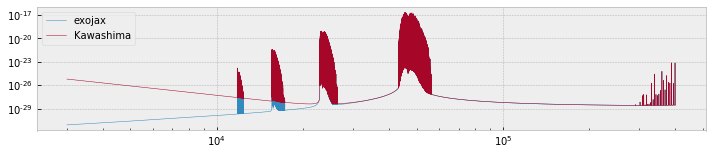

In [120]:
fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(211)
plt.plot(wls,xsv,lw=0.5,label="exojax")
plt.plot(w,absco,lw=0.5,label="Kawashima")
plt.yscale("log")
plt.xscale("log")
plt.legend(loc="upper left")
plt.savefig("co_hitran.png")
plt.show()

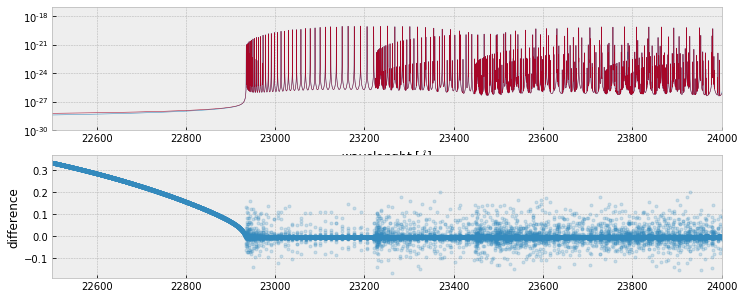

In [90]:
import matplotlib.pyplot as plt
#plt.plot(wls,xsv_l,lw=0.5,label="Lorentz")
fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(211)
plt.plot(wls,xsv,lw=0.5,label="exojax")
plt.plot(w,absco,lw=0.5,label="Kawashima")
plt.ylim(1.e-30,1.e-17)
plt.yscale("log")
plt.xlabel('wavelenght [$\AA$]')
plt.xlim(llow*10.0,lhigh*10.0)
ax=fig.add_subplot(212)
plt.plot(wmm,(abscomm-xsv)/abscomm,".",alpha=0.2)
plt.ylabel("difference")
plt.xlim(llow*10.0,lhigh*10.0)

#plt.legend()
plt.savefig("co_hitran.png")
plt.show()

In [ ]:
wmm[::-1]

In [99]:
print(numatrix.nbytes/1000/1000,"MB")

736.96 MB
